In [1]:
# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb#scrollTo=3SDhbo8lOBQv

import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pathlib

import tempfile
model_dir = tempfile.mkdtemp()

In [2]:
data_dir = pathlib.Path("./data/dogs-vs-cats/")

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))

In [4]:
SEED = 0
BATCH_SIZE = 128
BUFFER_SIZE=200
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = image_count//BATCH_SIZE
CLASS_NAMES = np.array(["cat", "dog"])

tf.random.set_seed(SEED)

In [5]:
def get_label(path):
    s_path = tf.strings.split(path, os.path.sep)[-1]
    label = tf.strings.split(s_path, ".")[0]
    if label == "cat":
        return 0
    else:
        return 1

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(path):
    label = get_label(path)
    img = tf.io.read_file(path)
    img = decode_img(img)
    return img, label

def scale_image(image, label):
    image = tf.image.per_image_standardization(image)
    return image, label

In [6]:
def input_fn():
    list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))
    
    return list_ds \
        .map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
        .map(scale_image) \
        .shuffle(BUFFER_SIZE) \
        .batch(BATCH_SIZE) \
        .prefetch(buffer_size=tf.data.experimental.AUTOTUNE) \
        .repeat()

for image, label in input_fn().take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.shape)

W0422 22:13:56.054414 140735545316224 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow_core/python/ops/image_ops_impl.py:1518: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Image shape:  (128, 224, 224, 3)
Label:  (128,)
Image shape:  (128, 224, 224, 3)
Label:  (128,)
Image shape:  (128, 224, 224, 3)
Label:  (128,)
Image shape:  (128, 224, 224, 3)
Label:  (128,)
Image shape:  (128, 224, 224, 3)
Label:  (128,)


In [7]:
train_ds = input_fn()

In [8]:
def model_fn():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer='adam',
                  loss=tf.losses.BinaryCrossentropy(from_logits=True), 
                  metrics=["accuracy"])
    
    return model

In [9]:
model = model_fn()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 394272)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                25233472  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 25,234,433
Trainable params: 25,234,433
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(train_ds, epochs = 10, steps_per_epoch = STEPS_PER_EPOCH)

Train for 195 steps
Epoch 1/10
195/195 [==============================] - 313s 2s/step - loss: 1.8836 - accuracy: 0.6518
Epoch 2/10
195/195 [==============================] - 315s 2s/step - loss: 0.5021 - accuracy: 0.7420
Epoch 3/10
195/195 [==============================] - 320s 2s/step - loss: 0.4185 - accuracy: 0.7927
Epoch 4/10
195/195 [==============================] - 335s 2s/step - loss: 0.3452 - accuracy: 0.8375
Epoch 5/10
195/195 [==============================] - 309s 2s/step - loss: 0.2988 - accuracy: 0.8632
Epoch 6/10
195/195 [==============================] - 895s 5s/step - loss: 0.2474 - accuracy: 0.8901
Epoch 7/10
195/195 [==============================] - 359s 2s/step - loss: 0.2067 - accuracy: 0.9125
Epoch 8/10
195/195 [==============================] - 387s 2s/step - loss: 0.1738 - accuracy: 0.9289
Epoch 9/10
195/195 [==============================] - 381s 2s/step - loss: 0.1264 - accuracy: 0.9532
Epoch 10/10
195/195 [==============================] - 421s 2s/step - l

In [11]:
acc = history.history['accuracy']
loss=history.history['loss']

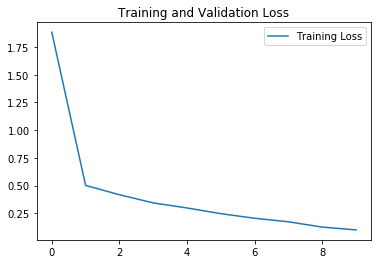

In [12]:
epochs_range = range(10)
# plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.evaluate()